In [1]:
# pyright: basic

from dataclasses import dataclass
import inspect
from typing import Self, cast
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import qutip as qt
import qutip.qip
from enum import Enum
from math import factorial, sqrt

# set a parameter to see animations in line
from matplotlib import rc
rc('animation', html='jshtml')

# static image plots
%matplotlib inline
# interactive 3D plots
# %matplotlib widget

In [40]:
class StateManager:
    def __init__(self):
        self.systems_list: list[qt.Qobj] = []

        # first index is system (entry of systems_list), second index is subsystem within that systems_list entry
        self.state_index_dict: dict[str, tuple[int, int]] = {}

    def add_subsystem(self, dimensions: int, key: str) -> None:
        # when we add a new subsystem, it will always be alone in a new independent system

        new_system = qt.basis(dimensions, 0)
        system_index = len(self.systems_list)
        self.systems_list += [new_system]
        self.state_index_dict[key] = (system_index, 0)
    
    def get_system_subsystems_count(self, system_index: int) -> int:
        count = 0
        for (sys_idx, sub_idx) in self.state_index_dict.values():
            if sys_idx == system_index:
                count += 1
        return count
        
    def ptrace_subsystem(self, key: str) -> None:
        system_index, target_subsystem_index = self.state_index_dict[key]
        prev_subsystem_count = self.get_system_subsystems_count(system_index)
        self.systems_list[system_index] = self.systems_list[system_index].ptrace([i for i in range(prev_subsystem_count) if i != target_subsystem_index])
        del self.state_index_dict[key]
        if(prev_subsystem_count > 1):
            for k, (v_sys, v_sub) in self.state_index_dict.items():
                if v_sys == system_index and v_sub > target_subsystem_index:
                    self.state_index_dict[k] = (system_index, v_sub-1)
        else:
            self.systems_list.pop(system_index)
            for k, (v_sys, v_sub) in self.state_index_dict.items():
                if v_sys > system_index:
                    self.state_index_dict[k] = (v_sys - 1, v_sub)
        
    def merge_systems(self, sys1: int, sys2: int) -> None:
        if sys2 < sys1:
            sys1, sys2 = sys2, sys1
        subsystem_count_1 = self.get_system_subsystems_count(sys1)
        s1 = self.systems_list[sys1]
        s2 = self.systems_list[sys2]
        if s1.isket and s2.isket:
            combined = qt.tensor(s1, s2)
        else:
            dm1 = qt.ket2dm(s1) if s1.isket else s1
            dm2 = qt.ket2dm(s2) if s2.isket else s2
            combined = qt.tensor(dm1, dm2)
        self.systems_list[sys1] = combined
        self.systems_list.pop(sys2)
        for k, (v_sys, v_sub) in self.state_index_dict.items():
            if v_sys == sys2:
                self.state_index_dict[k] = (sys1, subsystem_count_1+v_sub)
            elif v_sys > sys2:
                self.state_index_dict[k] = (v_sys - 1, v_sub)

    def ensure_same_system(self, key1: str, key2: str) -> None:
        sys1, _ = self.state_index_dict[key1]
        sys2, _ = self.state_index_dict[key2]
        if(sys1 != sys2):
            self.merge_systems(sys1, sys2)
    
    def ptrace_keep(self, keep_key_list: list[str], force_density_matrix: bool = True) -> qt.Qobj:
        for i in range(1, len(keep_key_list)):
            k = keep_key_list[i]
            self.ensure_same_system(keep_key_list[0], k)
        starting_key_list = list(self.state_index_dict.keys())
        for k in starting_key_list:
            if k not in keep_key_list:
                self.ptrace_subsystem(k)
        assert len(self.systems_list) == 1
        return qt.ket2dm(self.systems_list[0]) if force_density_matrix and self.systems_list[0].isket else self.systems_list[0]

    def clone(self) -> Self:
        new_manager = StateManager()
        # Create a new list with copies of each Qobj
        new_manager.systems_list = [state.copy() for state in self.systems_list]
        # Copy the dictionary
        new_manager.state_index_dict = self.state_index_dict.copy()
        return cast(Self, new_manager)

    def print_dimensions(self) -> None:
        print("\n--- Current StateManager Dimensions ---")
        for sys_idx, system in enumerate(self.systems_list):
            # QuTiP dims are formatted as [ [subsystem_dims], [subsystem_dims] ]
            # For a Qobj, dims[0] represents the dimensions of the Hilbert space
            current_dims = system.dims[0]
            
            # Find which keys belong to this system
            keys_in_system = [
                f"{k}(sub_idx:{sub})" 
                for k, (s_idx, sub) in self.state_index_dict.items() 
                if s_idx == sys_idx
            ]
            
            type_str = "Ket" if system.isket else "Density Matrix"
            print(f"System {sys_idx} ({type_str}):")
            print(f"  Dimensions: {current_dims}")
            print(f"  Keys: {', '.join(keys_in_system)}")
        print(f"Raw dict: {self.state_index_dict}")
        print("---------------------------------------\n")


In [41]:
def apply_x(sm: StateManager, target_key: str):
    system_index, target_idx = sm.state_index_dict[target_key]
    
    system = sm.systems_list[system_index]
    dims = system.dims[0]
    
    op_list = [qt.qeye(d) for d in dims]
    op_list[target_idx] = qt.gates.sigmax()
    
    X_total = qt.tensor(*op_list)
    if system.isket:
        sm.systems_list[system_index] = X_total @ system
    else:
        sm.systems_list[system_index] = X_total @ system @ X_total.dag()

def apply_z(sm: StateManager, target_key: str):
    system_index, target_idx = sm.state_index_dict[target_key]
    
    system = sm.systems_list[system_index]
    dims = system.dims[0]
    
    op_list = [qt.qeye(d) for d in dims]
    op_list[target_idx] = qt.gates.sigmax()
    
    X_total = qt.tensor(*op_list)
    if system.isket:
        sm.systems_list[system_index] = X_total @ system
    else:
        sm.systems_list[system_index] = X_total @ system @ X_total.dag()

def apply_hadamard(sm: StateManager, target_key: str):
    system_index, target_idx = sm.state_index_dict[target_key]

    system = sm.systems_list[system_index]
    dims = system.dims[0]

    op_list = [qt.qeye(d) for d in dims]
    
    # Place Hadamard at the target index
    op_list[target_idx] = qt.gates.snot()
    
    H_total = qt.tensor(*op_list)
    if system.isket:
        sm.systems_list[system_index] = H_total @ system
    else:
        sm.systems_list[system_index] =  H_total @ system @ H_total.dag()

def apply_cnot(sm: StateManager, control_key: str, target_key: str):
    sm.ensure_same_system(control_key, target_key)

    system_index, control_idx = sm.state_index_dict[control_key]
    _, target_idx = sm.state_index_dict[target_key]

    system = sm.systems_list[system_index]
    dims = system.dims[0]
    
    # Part 1: Control is in |0> (Identity on target)
    op_list_0 = [qt.qeye(d) for d in dims]
    op_list_0[control_idx] = qt.basis(2, 0).proj()
    # Target stays Identity, so no change needed to op_list_0
    
    # Part 2: Control is in |1> (X on target)
    op_list_1 = [qt.qeye(d) for d in dims]
    op_list_1[control_idx] = qt.basis(2, 1).proj()
    op_list_1[target_idx] = qt.sigmax()
    
    CNOT_total = qt.tensor(*op_list_0) + qt.tensor(*op_list_1)
    if system.isket:
        sm.systems_list[system_index] = CNOT_total @ system
    else:
        sm.systems_list[system_index] = CNOT_total @ system @ CNOT_total.dag()
    
def apply_swap(sm: StateManager, key1: str, key2: str):
    if(key1 == key2):
        return
    
    # A SWAP is 3 CNOTs
    apply_cnot(sm, key1, key2)
    apply_cnot(sm, key2, key1)
    apply_cnot(sm, key1, key2)

def apply_toffoli(sm: StateManager, ctrl1_key: str, ctrl2_key: str, target_key: str):
    sm.ensure_same_system(ctrl1_key, ctrl2_key)
    sm.ensure_same_system(ctrl1_key, target_key)

    system_index, ctrl1 = sm.state_index_dict[ctrl1_key]
    _, ctrl2 = sm.state_index_dict[ctrl2_key]
    _, target = sm.state_index_dict[target_key]

    system = sm.systems_list[system_index]
    dims = system.dims[0]

    # Identity on all subsystems
    op_list_id = [qt.qeye(d) for d in dims]
    
    # The Toffoli gate: I + |11><11| ⊗ (X - I)
    # This only acts when both controls are in the |1> state
    proj_11 = [qt.qeye(d) for d in dims]
    proj_11[ctrl1] = qt.basis(2, 1).proj()
    proj_11[ctrl2] = qt.basis(2, 1).proj()
    
    # The operator (X - I) on the target
    op_x_minus_i = [qt.qeye(d) for d in dims]
    op_x_minus_i[target] = qt.sigmax() - qt.qeye(2)
    
    # Combine: U = Identity + (Projector_11 * Target_Flip_Logic)
    # We use element-wise multiplication of the lists to build the tensor components
    U_toffoli = qt.tensor(*op_list_id) + (qt.tensor(*proj_11) @ qt.tensor(*op_list_id).dag() @ qt.tensor(*op_x_minus_i))
    
    if system.isket:
        sm.systems_list[system_index] = U_toffoli @ system
    else:
        sm.systems_list[system_index] = U_toffoli @ system @ U_toffoli.dag()




In [42]:
def apply_cat_state_encoding(sm: StateManager, qubit_key: str, cv_key: str, vertical_displacement: float, N: int):
    # 1. Prepare CV states
    vacuum = qt.basis(N, 0)
    alpha_coeff = (vertical_displacement / np.sqrt(2)) * 1j
    
    pos_disp = qt.displace(N, alpha_coeff)
    neg_disp = qt.displace(N, -alpha_coeff)
    
    logical_zero = (pos_disp @ vacuum + neg_disp @ vacuum).unit()
    logical_one  = (pos_disp @ vacuum - neg_disp @ vacuum).unit()
    
    # Define the mapping operators for the CV mode
    map_zero = logical_zero @ vacuum.dag()
    map_one  = logical_one @ vacuum.dag()

    # 2. Build the operator list for the tensor product
    sm.ensure_same_system(qubit_key, cv_key)
    system_index, qubit_position = sm.state_index_dict[qubit_key]
    _, cv_position = sm.state_index_dict[cv_key]

    system = sm.systems_list[system_index]
    dims = system.dims[0]
    num_subsystems = len(dims)

    def build_gate(qubit_state_index: int) -> qt.Qobj:
        op_list = [qt.qeye(dims[i]) for i in range(num_subsystems)]
        
        if qubit_state_index == 0:
            # Map: |0>_q |vac>_cv  ->  |0>_q |cat+>_cv
            op_list[qubit_position] = qt.basis(2, 0).proj()
            op_list[cv_position] = map_zero
        else:
            # Map: |1>_q |vac>_cv  ->  |0>_q |cat->_cv
            # We use |0><1| to flip the qubit from 1 to 0 during the transfer
            op_list[qubit_position] = qt.basis(2, 0) @ qt.basis(2, 1).dag()
            op_list[cv_position] = map_one
        
        return qt.tensor(*op_list)

    # 3. Combine into the full encoding operator
    U_encode = build_gate(0) + build_gate(1)

    # return U_encode * input_states
    if system.isket:
        sm.systems_list[system_index] = U_encode @ system
    else:
        sm.systems_list[system_index] = U_encode @ system @ U_encode.dag()

def apply_ideal_cat_state_decoding(sm: StateManager, qubit_key: str, cv_key: str, vertical_displacement: float, N: int):
    sm.ensure_same_system(qubit_key, cv_key)
    system_index, qubit_position = sm.state_index_dict[qubit_key]
    _, cv_position = sm.state_index_dict[cv_key]

    system = sm.systems_list[system_index]
    dims = system.dims[0]
    
    # 1. Define states
    vacuum = qt.basis(N, 0)
    alpha_coeff = (vertical_displacement / np.sqrt(2)) * 1j
    
    # Define logical states for parity detection
    pos_disp = qt.displace(N, alpha_coeff)
    neg_disp = qt.displace(N, -alpha_coeff)
    logical_zero_cv = (pos_disp @ vacuum + neg_disp @ vacuum).unit()
    logical_one_cv  = (pos_disp @ vacuum - neg_disp @ vacuum).unit()

    # 2. Step A: Parity-Controlled Qubit Flip (The "Decoding")
    # This maps: |cat+>|0> -> |cat+>|0>  AND  |cat->|0> -> |cat->|1>
    def build_flip():
        # Project CV onto Parity, apply corresponding gate to Qubit
        op_plus = [qt.qeye(d) for d in dims]
        op_plus[cv_position] = logical_zero_cv.proj()
        # Qubit stays same (Identity)
        
        op_minus = [qt.qeye(d) for d in dims]
        op_minus[cv_position] = logical_one_cv.proj()
        op_minus[qubit_position] = qt.sigmax() # Flip if odd parity
        
        return qt.tensor(*op_plus) + qt.tensor(*op_minus)

    # 3. Step B: Qubit-Controlled Un-displacement (The "Cleaning")
    # This returns the CV mode to vacuum: |cat+>|0> -> |vac>|0> AND |cat->|1> -> |vac>|1>
    # Note: This is essentially the inverse of your encoding function.
    def build_clean():
        # This part ensures the operation is unitary by resetting the CV mode
        op_zero = [qt.qeye(d) for d in dims]
        op_zero[qubit_position] = qt.basis(2, 0).proj()
        op_zero[cv_position] = vacuum @ logical_zero_cv.dag()
        
        op_one = [qt.qeye(d) for d in dims]
        op_one[qubit_position] = qt.basis(2, 1).proj()
        op_one[cv_position] = vacuum @ logical_one_cv.dag()
        
        return qt.tensor(*op_zero) + qt.tensor(*op_one)

    # Combined Unitary: First flip the qubit, then clean the CV mode
    U_total = build_clean() @ build_flip()
    
    # Inside apply_ideal_cat_state_decoding:
    if system.isket:
        sm.systems_list[system_index] = U_total @ system
    else:
        sm.systems_list[system_index] = U_total @ system @ U_total.dag()

def apply_kitten_state_encoding(sm: StateManager, qubit_key: str, cv_key: str, N: int):
    sm.ensure_same_system(qubit_key, cv_key)
    system_index, qubit_pos = sm.state_index_dict[qubit_key]
    _, cv_pos = sm.state_index_dict[cv_key]
    
    system = sm.systems_list[system_index]
    dims = system.dims[0]

    logical_zero = (qt.basis(N, 0) + qt.basis(N, 4)).unit()
    logical_one = qt.basis(N, 2)

    map_zero = logical_zero @ qt.basis(N, 0).dag()
    map_one  = logical_one @ qt.basis(N, 0).dag()

    op0 = [qt.qeye(d) for d in dims]
    op0[qubit_pos] = qt.basis(2, 0).proj()
    op0[cv_pos] = map_zero

    op1 = [qt.qeye(d) for d in dims]
    op1[qubit_pos] = qt.basis(2, 0) @ qt.basis(2, 1).dag()
    op1[cv_pos] = map_one

    U_encode = qt.tensor(*op0) + qt.tensor(*op1)
    
    if system.isket:
        sm.systems_list[system_index] = U_encode @ system
    else:
        sm.systems_list[system_index] = U_encode @ system @ U_encode.dag()

def apply_kitten_state_decoding(sm: StateManager, qubit_key: str, cv_key: str, N: int):
    sm.ensure_same_system(qubit_key, cv_key)
    anc_key = "parity_ancilla"
    sm.add_subsystem(2, anc_key)
    sm.ensure_same_system(cv_key, anc_key)
    
    sys_idx, qubit_pos = sm.state_index_dict[qubit_key]
    _, cv_pos = sm.state_index_dict[cv_key]
    _, anc_pos = sm.state_index_dict[anc_key]
    
    system = sm.systems_list[sys_idx]
    dims = system.dims[0]

    parity_check = 0
    for n in range(N):
        proj_n = qt.basis(N, n).proj()
        op_list = [qt.qeye(d) for d in dims]
        op_list[cv_pos] = proj_n
        if n % 2 != 0:
            op_list[anc_pos] = qt.sigmax()
        parity_check += qt.tensor(*op_list)
    parity_check = cast(qt.Qobj, parity_check)

    l0 = (qt.basis(N, 0) + qt.basis(N, 4)).unit()
    l1 = qt.basis(N, 2)

    a = qt.destroy(N)

    e0 = (a @ l0).unit()
    e1 = (a @ l1).unit()

    P_l0 = l0 @ l0.dag()
    P_l1 = l1 @ l1.dag()
    P_e0 = e0 @ e0.dag()
    P_e1 = e1 @ e1.dag()

    I_cv = qt.qeye(N)
    P_sub = P_l0 + P_l1 + P_e0 + P_e1
    P_perp = I_cv - P_sub

    U_corr_cv = (
        l0 @ e0.dag()
        + l1 @ e1.dag()
        + e0 @ l0.dag()
        + e1 @ l1.dag()
        + P_perp
    )

    op_list_no_err = [qt.qeye(d) for d in dims]
    op_list_no_err[anc_pos] = qt.basis(2, 0).proj()
    term_no_err = qt.tensor(*op_list_no_err)

    op_list_err = [qt.qeye(d) for d in dims]
    op_list_err[anc_pos] = qt.basis(2, 1).proj()
    op_list_err[cv_pos] = U_corr_cv
    term_err = qt.tensor(*op_list_err)

    recovery_gate = term_no_err + term_err

    U_correct = recovery_gate @ parity_check

    if system.isket:
        system = U_correct @ system
    else:
        system = U_correct @ system @ U_correct.dag()
    
    sm.systems_list[sys_idx] = system
    sm.ptrace_subsystem(anc_key)

    sys_idx, qubit_pos = sm.state_index_dict[qubit_key]
    _, cv_pos = sm.state_index_dict[cv_key]
    system = sm.systems_list[sys_idx]
    dims = system.dims[0]

    l0 = (qt.basis(N, 0) + qt.basis(N, 4)).unit()
    l1 = qt.basis(N, 2)
    vac = qt.basis(N, 0)

    op_map0 = [qt.qeye(d) for d in dims]
    op_map0[qubit_pos] = qt.basis(2, 0).proj()
    op_map0[cv_pos] = vac @ l0.dag()

    op_map1 = [qt.qeye(d) for d in dims]
    op_map1[qubit_pos] = qt.basis(2, 1) @ qt.basis(2, 0).dag()
    op_map1[cv_pos] = vac @ l1.dag()

    U_decode = qt.tensor(*op_map0) + qt.tensor(*op_map1)

    if system.isket:
        sm.systems_list[sys_idx] = (U_decode @ system).unit()
    else:
        res = U_decode @ system @ U_decode.dag()
        sm.systems_list[sys_idx] = res / res.tr()

def apply_kraus_loss(
    sm: StateManager,
    key: str,
    loss_prob: float,
    k_max: int | None = None
):
    system_index, local_idx = sm.state_index_dict[key]
    system = sm.systems_list[system_index]

    if system.isket:
        system = qt.ket2dm(system)

    dims = system.dims[0]
    N = dims[local_idx]
    assert isinstance(N, int)

    eta = 1.0 - loss_prob
    if k_max is None:
        k_max = N - 1

    a = qt.destroy(N)
    n = a.dag() @ a

    eta_n: qt.Qobj = (0.5 * np.log(eta) * n).expm()

    id_ops = [qt.qeye(d) for d in dims]
    rho_out = 0 * system

    for k in range(k_max + 1):
        Ak_local = (
            ((1 - eta) ** (k / 2))
            / np.sqrt(float(factorial(k)))
            * eta_n
            * (a ** k)
        )

        op_list = id_ops.copy()
        op_list[local_idx] = Ak_local
        K = qt.tensor(*op_list)

        rho_out += K @ system @ K.dag()

    sm.systems_list[system_index] = rho_out


In [ ]:
def swap_encode(sm: StateManager, source_key: str, target_key_list: list[str]):
    apply_swap(sm, source_key, target_key_list[0])

def swap_decode(sm: StateManager, target_key: str, source_key_list: list[str]):
    apply_swap(sm, source_key_list[0], target_key)

def repetition_encode(sm: StateManager, source_key: str, target_key_list: list[str]):
    apply_swap(sm, source_key, target_key_list[0])
    for i in range(1, len(target_key_list)):
        target_key = target_key_list[i]
        apply_cnot(sm, target_key_list[0], target_key)

def repetition_decode(sm: StateManager, target_key: str, source_key_list: list[str]):
    if len(source_key_list) == 3:
        for i in range(1, len(source_key_list)):
            apply_cnot(sm, source_key_list[0], source_key_list[i])
        apply_toffoli(sm, source_key_list[1], source_key_list[2], source_key_list[0])
    else:
        print("unsupported decoding for n != 3")
        exit()
    apply_swap(sm, source_key_list[0], target_key)

def phase_repetition_encode(sm: StateManager, source_key: str, target_key_list: list[str]):
    apply_hadamard(sm, source_key)
    repetition_encode(sm, source_key, target_key_list)
    for idx in target_key_list:
        apply_hadamard(sm, idx)

def phase_repetition_decode(sm: StateManager, target_key: str, source_key_list: list[str]):
    for idx in source_key_list:
        apply_hadamard(sm, idx)
    repetition_decode(sm, target_key, source_key_list)
    apply_hadamard(sm, target_key)

def shor_encode(sm: StateManager, source_key: str, target_key_list: list[str]):
    if len(target_key_list) != 9:
        raise ValueError("Shor code requires exactly 9 channel qubits")

    q = target_key_list

    phase_repetition_encode(sm, source_key, [q[0], q[3], q[6]])

    repetition_encode(sm, q[0], [q[0], q[1], q[2]])
    repetition_encode(sm, q[3], [q[3], q[4], q[5]])
    repetition_encode(sm, q[6], [q[6], q[7], q[8]])

def shor_decode(sm: StateManager, target_key: str, source_key_list: list[str]):
    if len(source_key_list) != 9:
        raise ValueError("Shor code requires exactly 9 channel qubits")

    q = source_key_list

    repetition_decode(sm, q[0], [q[0], q[1], q[2]])
    repetition_decode(sm, q[3], [q[3], q[4], q[5]])
    repetition_decode(sm, q[6], [q[6], q[7], q[8]])

    phase_repetition_decode(sm, target_key, [q[0], q[3], q[6]])

def wrap_repetition_encode(sm: StateManager, source_key: str, target_key_list: list[str]):
    if len(target_key_list) != 9:
        raise ValueError("wrap_repetition code requires exactly 9 channel qubits")

    q = target_key_list

    repetition_encode(sm, source_key, [q[0], q[3], q[6]])

    repetition_encode(sm, q[0], [q[0], q[1], q[2]])
    repetition_encode(sm, q[3], [q[3], q[4], q[5]])
    repetition_encode(sm, q[6], [q[6], q[7], q[8]])

def wrap_repetition_decode(sm: StateManager, target_key: str, source_key_list: list[str]):
    if len(source_key_list) != 9:
        raise ValueError("wrap_repetition code requires exactly 9 channel qubits")

    q = source_key_list

    repetition_decode(sm, q[0], [q[0], q[1], q[2]])
    repetition_decode(sm, q[3], [q[3], q[4], q[5]])
    repetition_decode(sm, q[6], [q[6], q[7], q[8]])

    repetition_decode(sm, target_key, [q[0], q[3], q[6]])

def phase_wrap_repetition_encode(sm: StateManager, source_key: str, target_key_list: list[str]):
    apply_hadamard(sm, source_key)
    wrap_repetition_encode(sm, source_key, target_key_list)
    for idx in target_key_list:
        apply_hadamard(sm, idx)

def phase_wrap_repetition_decode(sm: StateManager, target_key: str, source_key_list: list[str]):
    for idx in source_key_list:
        apply_hadamard(sm, idx)
    wrap_repetition_decode(sm, target_key, source_key_list)
    apply_hadamard(sm, target_key)











class ChannelType(Enum):
    CV_CAT = 1
    CV_KITTEN = 2
    DV_SINGLE_MODE = 3
    DV_DUAL_MODE_MIXED = 4

@dataclass
class PhyLayerConfiguration:
    channel_type: ChannelType
    N: int = 2
    vertical_displacement: float | None = None

    def __post_init__(self):
        if self.channel_type == ChannelType.CV_CAT:
            if self.N is None or self.vertical_displacement is None:
                raise ValueError(
                    f"ChannelType.CV_CAT requires both 'N' and 'vertical_displacement'. "
                    f"Got: N={self.N}, displacement={self.vertical_displacement}"
                )
        if self.channel_type == ChannelType.CV_KITTEN:
            if self.N < 5:
                raise ValueError(
                    f"N={self.N} too low for Kitten state (min N=5)"
                )

class EncodingType(Enum):
    SWAP_DUMMY_ENCODING = 1
    REPETITION_BIT_FLIP = 2
    REPETITION_PHASE_FLIP = 3
    SHOR_9_QUBITS = 4
    REPETITION_BIT_FLIP_WRAP = 5
    REPETITION_PHASE_FLIP_WRAP = 6

def generic_encode(sm: StateManager, source_key: str, target_key_list: list[str], encoding: EncodingType):
    if encoding is EncodingType.SWAP_DUMMY_ENCODING:
        swap_encode(sm, source_key, target_key_list)
    elif encoding is EncodingType.REPETITION_BIT_FLIP:
        repetition_encode(sm, source_key, target_key_list)
    elif encoding is EncodingType.REPETITION_PHASE_FLIP:
        phase_repetition_encode(sm, source_key, target_key_list)
    elif encoding is EncodingType.SHOR_9_QUBITS:
        shor_encode(sm, source_key, target_key_list)
    elif encoding is EncodingType.REPETITION_BIT_FLIP_WRAP:
        wrap_repetition_encode(sm, source_key, target_key_list)
    elif encoding is EncodingType.REPETITION_PHASE_FLIP_WRAP:
        phase_wrap_repetition_encode(sm, source_key, target_key_list)

def generic_decode(sm: StateManager, target_key: str, source_key_list: list[str], encoding: EncodingType):
    if encoding is EncodingType.SWAP_DUMMY_ENCODING:
        swap_decode(sm, target_key, source_key_list)
    elif encoding is EncodingType.REPETITION_BIT_FLIP:
        repetition_decode(sm, target_key, source_key_list)
    elif encoding is EncodingType.REPETITION_PHASE_FLIP:
        phase_repetition_decode(sm, target_key, source_key_list)
    elif encoding is EncodingType.SHOR_9_QUBITS:
        shor_decode(sm, target_key, source_key_list)
    elif encoding is EncodingType.REPETITION_BIT_FLIP_WRAP:
        wrap_repetition_decode(sm, target_key, source_key_list)
    elif encoding is EncodingType.REPETITION_PHASE_FLIP_WRAP:
        phase_wrap_repetition_decode(sm, target_key, source_key_list)


In [ ]:
ideal_phi_plus = (qt.tensor(qt.basis(2,0), qt.basis(2,0)) + qt.tensor(qt.basis(2,1), qt.basis(2,1))).unit()
ideal_rho = qt.ket2dm(ideal_phi_plus)


def run_fidelity_simulation(ph: PhyLayerConfiguration, loss_prob: float, NUM_CHANNEL_QUBITS: int, encoding_type: EncodingType) -> float:
    N = ph.N

    sm = StateManager()

    sm.add_subsystem(2, "tx_edge")
    sm.add_subsystem(2, "tx_temp")

    apply_hadamard(sm, "tx_edge")
    apply_cnot(sm, "tx_edge", "tx_temp")

    for i in range(NUM_CHANNEL_QUBITS):
        sm.add_subsystem(2, f"channel_{i}_tx")
    
    generic_encode(sm, "tx_temp", [f"channel_{i}_tx" for i in range(NUM_CHANNEL_QUBITS)], encoding_type)
    sm.ptrace_subsystem("tx_temp")

    for i in range(NUM_CHANNEL_QUBITS):
        sm.add_subsystem(2, f"channel_{i}_rx")
        if ph.channel_type is ChannelType.CV_CAT:
            assert ph.vertical_displacement is not None
            sm.add_subsystem(N, f"channel_{i}_cat")
            apply_cat_state_encoding(sm, f"channel_{i}_tx", f"channel_{i}_cat", ph.vertical_displacement, N)
            sm.ptrace_subsystem(f"channel_{i}_tx")
            apply_kraus_loss(sm, f"channel_{i}_cat", loss_prob)
            apply_ideal_cat_state_decoding(sm, f"channel_{i}_rx", f"channel_{i}_cat", ph.vertical_displacement, N)
            sm.ptrace_subsystem(f"channel_{i}_cat")
        if ph.channel_type is ChannelType.CV_KITTEN:
            sm.add_subsystem(N, f"channel_{i}_kitten")
            apply_kitten_state_encoding(sm, f"channel_{i}_tx", f"channel_{i}_kitten", N)
            sm.ptrace_subsystem(f"channel_{i}_tx")
            apply_kraus_loss(sm, f"channel_{i}_kitten", loss_prob)
            apply_kitten_state_decoding(sm, f"channel_{i}_rx", f"channel_{i}_kitten", N)
            sm.ptrace_subsystem(f"channel_{i}_kitten")

    sm.add_subsystem(2, "rx_edge")

    generic_decode(sm, "rx_edge", [f"channel_{i}_rx" for i in range(NUM_CHANNEL_QUBITS)], encoding_type)

    for i in range(NUM_CHANNEL_QUBITS):
        sm.ptrace_subsystem(f"channel_{i}_rx")

    edge_qubits = sm.ptrace_keep(["tx_edge", "rx_edge"]).unit()
    fid = qt.fidelity(edge_qubits, ideal_rho)
    return fid




In [ ]:


phy_config_list: list[tuple[PhyLayerConfiguration, list[tuple[EncodingType, int]]]] = [
    (
        PhyLayerConfiguration(channel_type=ChannelType.CV_KITTEN, N=5), 
        [
            (EncodingType.SWAP_DUMMY_ENCODING, 1),
            (EncodingType.REPETITION_BIT_FLIP, 3),
            (EncodingType.REPETITION_PHASE_FLIP, 3),
            (EncodingType.SHOR_9_QUBITS, 9),
            (EncodingType.REPETITION_BIT_FLIP_WRAP, 9),
        ]
    ),
    (
        PhyLayerConfiguration(channel_type=ChannelType.CV_CAT, N=18, vertical_displacement=1.5), 
        [
            (EncodingType.SWAP_DUMMY_ENCODING, 1),
            (EncodingType.REPETITION_BIT_FLIP, 3),
            (EncodingType.SHOR_9_QUBITS, 9),
            (EncodingType.REPETITION_BIT_FLIP_WRAP, 9),
        ]
    ),
]

loss_prob_list = np.logspace(np.log10(0.01), np.log10(0.9), num=40)


# Define line styles for different physical layers to distinguish them
styles = {
    ChannelType.CV_CAT: "solid",
    ChannelType.CV_KITTEN: "dotted",
    ChannelType.DV_SINGLE_MODE: "dashed",
    ChannelType.DV_DUAL_MODE_MIXED: "dashdot",
}


for phy_config, codes in phy_config_list:
    mode_name = "CV-CAT" if phy_config.channel_type is ChannelType.CV_CAT else "CV-KIT" if phy_config.channel_type is ChannelType.CV_KITTEN else "DV-1M" if phy_config.channel_type is ChannelType.DV_SINGLE_MODE else "DV-2M-MIXED"
    ls = styles[phy_config.channel_type]
    
    print(f"phy_config.channel_type: {phy_config.channel_type.name}")

    # For each encoding/qubit-count pair in the config
    for encoding_type, num_qubits in codes:
        fidelities = []
        label = f"[{mode_name}] {encoding_type.name} ({num_qubits} qubits)"
        
        print(f"\tencoding_type: {encoding_type.name}")
        
        for loss_prob in loss_prob_list:
            print(f"\t\tloss_prob: {loss_prob}")
            fid = run_fidelity_simulation(
                ph=phy_config, 
                loss_prob=loss_prob, 
                NUM_CHANNEL_QUBITS=num_qubits, 
                encoding_type=encoding_type
            )
            fidelities.append(fid)
            
        # Plot this specific line
        plt.loglog(loss_prob_list, fidelities, ls=ls, label=label)

# Formatting the Plot
plt.xlabel('Loss Probability')
plt.ylabel('Fidelity')
plt.title('Fidelity vs Channel Loss for Different Encodings')

# Place legend outside if it gets too crowded
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)

plt.show()

displacement h 3.5355339059327378 v 0.0


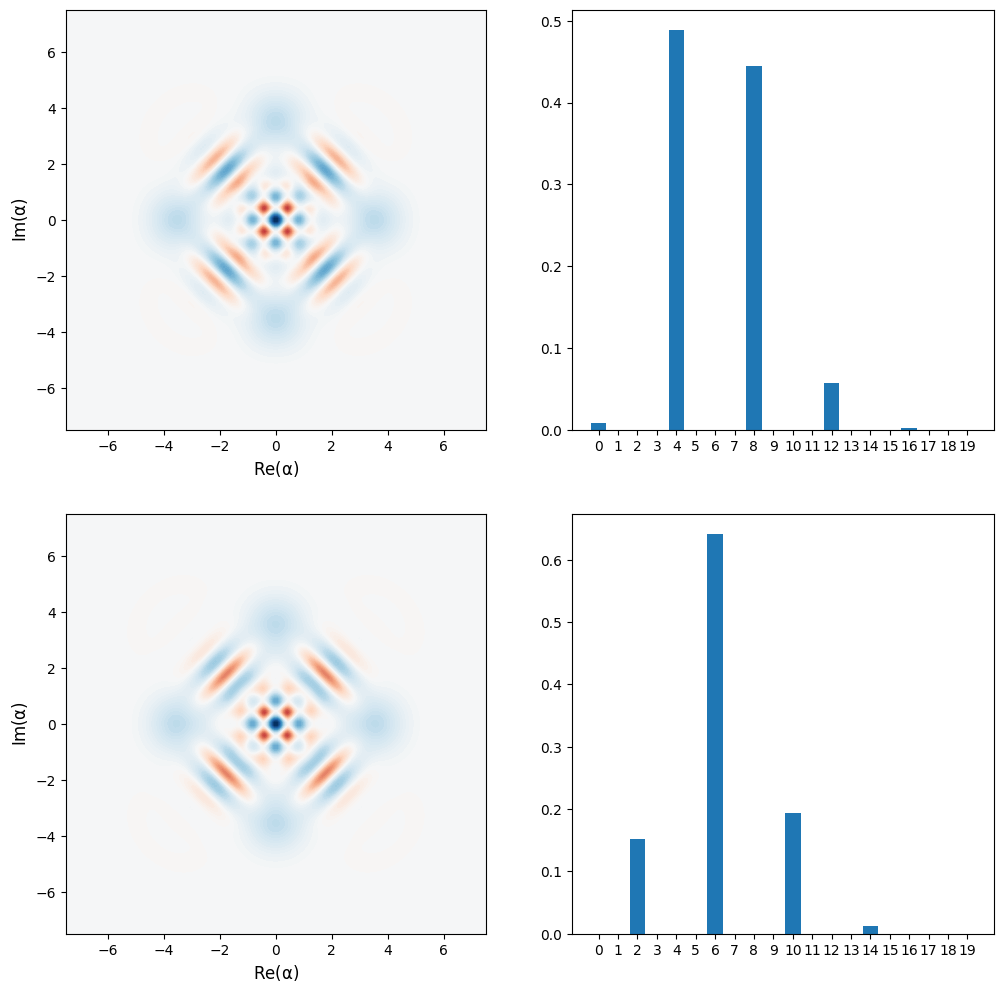

SystemExit: 

/home/riccardo/Desktop/quantum-workspace/venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3709: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [38]:
# pyright: basic

from dataclasses import dataclass
import inspect
from typing import Self, cast
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import qutip as qt
import qutip.qip
from enum import Enum
from math import factorial, sqrt

# set a parameter to see animations in line
from matplotlib import rc
rc('animation', html='jshtml')

# static image plots
%matplotlib inline
# interactive 3D plots
# %matplotlib widget

def photon_count_distribution(state: qt.Qobj):
    """
    Returns the photon number distribution P(n) for any state.
    """
    if state.isket:
        return np.abs(state.full().flatten())**2
    else:
        return np.real(state.diag())

N = 20
alpha: complex = 2.5

print(f"displacement h {sqrt(2) * alpha.real} v {sqrt(2) * alpha.imag}")


vacuum = qt.basis(N, 0)

plus_alpha = qt.displace(N, alpha) @ vacuum # type: ignore
minus_alpha = qt.displace(N, -alpha) @ vacuum # type: ignore
plus_i_alpha = qt.displace(N, alpha*1j) @ vacuum # type: ignore
minus_i_alpha = qt.displace(N, -alpha*1j) @ vacuum # type: ignore

# fig, axes = plt.subplots(2, 2, figsize=(12, 12),  subplot_kw={'aspect': 'equal'})
# qutip.plot_wigner(plus_alpha, ax=axes[0, 0])
# axes[0, 0].set_title("+alpha")
# qutip.plot_wigner(minus_alpha, ax=axes[1, 0])
# axes[1, 0].set_title("-alpha")
# qutip.plot_wigner(plus_i_alpha, ax=axes[0, 1])
# axes[0, 1].set_title("+i alpha")
# qutip.plot_wigner(minus_i_alpha, ax=axes[1, 1])
# axes[1, 1].set_title("-i alpha")
# plt.tight_layout()

# fig, axes = plt.subplots(2, 2, figsize=(12, 12),  subplot_kw={'aspect': 'equal'})
# axes[0, 0].bar(np.arange(N), photon_count_distribution(plus_alpha))
# axes[0, 0].set_xticks(np.arange(N))
# axes[0, 0].set_aspect('auto')
# axes[0, 0].set_title("+alpha")
# axes[1, 0].bar(np.arange(N), photon_count_distribution(plus_alpha))
# axes[1, 0].set_xticks(np.arange(N))
# axes[1, 0].set_aspect('auto')
# axes[1, 0].set_title("-alpha")
# axes[0, 1].bar(np.arange(N), photon_count_distribution(plus_alpha))
# axes[0, 1].set_xticks(np.arange(N))
# axes[0, 1].set_aspect('auto')
# axes[0, 1].set_title("+i alpha")
# axes[1, 1].bar(np.arange(N), photon_count_distribution(plus_alpha))
# axes[1, 1].set_xticks(np.arange(N))
# axes[1, 1].set_aspect('auto')
# axes[1, 1].set_title("-i alpha")
# plt.tight_layout()


plus_state_horiz = (plus_alpha + minus_alpha).unit()
minus_state_horiz = (plus_alpha - minus_alpha).unit()
plus_state_vert = (plus_i_alpha + minus_i_alpha).unit()
minus_state_vert = (plus_i_alpha - minus_i_alpha).unit()

logical_zero = (plus_state_horiz + plus_state_vert).unit()
logical_one = (plus_state_horiz - plus_state_vert).unit()


fig, axes = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'aspect': 'equal'})
qutip.plot_wigner(logical_zero, ax=axes[0, 0])
qutip.plot_wigner(logical_one, ax=axes[1, 0])
axes[0, 1].bar(np.arange(N), photon_count_distribution(logical_zero))
axes[0, 1].set_xticks(np.arange(N))
axes[0, 1].set_aspect('auto')
axes[1, 1].bar(np.arange(N), photon_count_distribution(logical_one))
axes[1, 1].set_xticks(np.arange(N))
axes[1, 1].set_aspect('auto')


plt.show()

raise SystemExit

In [ ]:
def apply_4_legged_cat_encoding(sm: StateManager, qubit_key: str, cv_key: str, alpha: complex, N: int):
    """
    Encodes a qubit state into a 4-legged cat state.
    |0>_q -> |cat_00> (Even-Even: 0, 4, 8... photons)
    |1>_q -> |cat_01> (Even-Odd: 2, 6, 10... photons)
    """
    sm.ensure_same_system(qubit_key, cv_key)
    system_index, qubit_pos = sm.state_index_dict[qubit_key]
    _, cv_pos = sm.state_index_dict[cv_key]
    
    system = sm.systems_list[system_index]
    dims = system.dims[0]

    # 1. Prepare the coherent components
    vac = qt.basis(N, 0)
    c_p = qt.displace(N, alpha) @ vac
    c_m = qt.displace(N, -alpha) @ vac
    c_ip = qt.displace(N, 1j * alpha) @ vac
    c_im = qt.displace(N, -1j * alpha) @ vac

    # 2. Define Logical States (a1 and a2 from your testing script)
    # Logical zero contains Fock states 0, 4, 8...
    logical_zero = (c_p + c_m + c_ip + c_im).unit()
    # Logical one contains Fock states 2, 6, 10...
    logical_one = (c_p + c_m - c_ip - c_im).unit()

    # 3. Define mapping operators
    # We map |vac> in CV to the cat states while flipping qubit to |0>
    map_zero = logical_zero @ vac.dag()
    map_one  = logical_one @ vac.dag()

    op0 = [qt.qeye(d) for d in dims]
    op0[qubit_pos] = qt.basis(2, 0).proj()
    op0[cv_pos] = map_zero

    op1 = [qt.qeye(d) for d in dims]
    op1[qubit_pos] = qt.basis(2, 0) @ qt.basis(2, 1).dag()
    op1[cv_pos] = map_one

    U_encode = qt.tensor(*op0) + qt.tensor(*op1)
    
    if system.isket:
        sm.systems_list[system_index] = U_encode @ system
    else:
        sm.systems_list[system_index] = U_encode @ system @ U_encode.dag()
def apply_4_legged_cat_decoding(sm: StateManager, qubit_key: str, cv_key: str, alpha: complex, N: int):
    """
    Decodes a 4-legged cat state back into a qubit.
    Uses an ancilla to detect odd-parity errors (single photon loss) 
    and applies a recovery rotation before projection.
    """
    sm.ensure_same_system(qubit_key, cv_key)
    anc_key = "cat_decoding_ancilla"
    sm.add_subsystem(2, anc_key)
    sm.ensure_same_system(cv_key, anc_key)
    
    sys_idx, qubit_pos = sm.state_index_dict[qubit_key]
    _, cv_pos = sm.state_index_dict[cv_key]
    _, anc_pos = sm.state_index_dict[anc_key]
    
    system = sm.systems_list[sys_idx]
    dims = system.dims[0]

    # --- PART A: PARITY CHECK ---
    # Construct an operator that flips the ancilla if CV photon number is odd
    parity_check = 0
    for n in range(N):
        proj_n = qt.basis(N, n).proj()
        op_list = [qt.qeye(d) for d in dims]
        op_list[cv_pos] = proj_n
        if n % 2 != 0:
            op_list[anc_pos] = qt.sigmax()
        parity_check += qt.tensor(*op_list)
    parity_check = cast(qt.Qobj, parity_check)

    # --- PART B: RECOVERY UNITARY ---
    # Define the original logical states
    vac = qt.basis(N, 0)
    l0 = (qt.displace(N, alpha) @ vac + qt.displace(N, -alpha) @ vac + 
          qt.displace(N, 1j*alpha) @ vac + qt.displace(N, -1j*alpha) @ vac).unit()
    l1 = (qt.displace(N, alpha) @ vac + qt.displace(N, -alpha) @ vac - 
          qt.displace(N, 1j*alpha) @ vac - qt.displace(N, -1j*alpha) @ vac).unit()

    # Define the 'error' states (what happens after one photon loss 'a')
    a = qt.destroy(N)
    e0 = (a @ l0).unit()
    e1 = (a @ l1).unit()

    # Recovery Unitary: If we find ourselves in the error states, rotate them back
    # This is essentially a 90-degree phase rotation
    P_e0 = e0 @ e0.dag()
    P_e1 = e1 @ e1.dag()
    P_l0 = l0 @ l0.dag()
    P_l1 = l1 @ l1.dag()
    
    I_cv = qt.qeye(N)
    U_corr_cv = (l0 @ e0.dag()) + (l1 @ e1.dag()) + (e0 @ l0.dag()) + (e1 @ l1.dag()) + (I_cv - P_e0 - P_e1 - P_l0 - P_l1)

    # Apply recovery only if the ancilla detected odd parity (|1>)
    op_list_no_err = [qt.qeye(d) for d in dims]
    op_list_no_err[anc_pos] = qt.basis(2, 0).proj()
    
    op_list_err = [qt.qeye(d) for d in dims]
    op_list_err[anc_pos] = qt.basis(2, 1).proj()
    op_list_err[cv_pos] = U_corr_cv
    
    recovery_gate = qt.tensor(*op_list_no_err) + qt.tensor(*op_list_err)
    U_total = recovery_gate @ parity_check

    if system.isket:
        system = U_total @ system
    else:
        system = U_total @ system @ U_total.dag()
    
    sm.systems_list[sys_idx] = system
    sm.ptrace_subsystem(anc_key)

    # --- PART C: FINAL DECODING (CV -> QUBIT) ---
    # Re-fetch indices after ptrace
    sys_idx, qubit_pos = sm.state_index_dict[qubit_key]
    _, cv_pos = sm.state_index_dict[cv_key]
    system = sm.systems_list[sys_idx]
    dims = system.dims[0]

    op_map0 = [qt.qeye(d) for d in dims]
    op_map0[qubit_pos] = qt.basis(2, 0).proj()
    op_map0[cv_pos] = vac @ l0.dag()

    op_map1 = [qt.qeye(d) for d in dims]
    op_map1[qubit_pos] = qt.basis(2, 1) @ qt.basis(2, 0).dag()
    op_map1[cv_pos] = vac @ l1.dag()

    U_decode = qt.tensor(*op_map0) + qt.tensor(*op_map1)

    if system.isket:
        sm.systems_list[sys_idx] = (U_decode @ system).unit()
    else:
        res = U_decode @ system @ U_decode.dag()
        sm.systems_list[sys_idx] = res / res.tr()


def swap_encode(sm: StateManager, source_key: str, target_key_list: list[str]):
    apply_swap(sm, source_key, target_key_list[0])

def swap_decode(sm: StateManager, target_key: str, source_key_list: list[str]):
    apply_swap(sm, source_key_list[0], target_key)


ideal_phi_plus = (qt.tensor(qt.basis(2,0), qt.basis(2,0)) + qt.tensor(qt.basis(2,1), qt.basis(2,1))).unit()
ideal_rho = qt.ket2dm(ideal_phi_plus)

NUM_CHANNEL_QUBITS = 1
loss_prob = 0.1

sm = StateManager()

sm.add_subsystem(2, "tx_edge")
sm.add_subsystem(2, "tx_temp")

apply_hadamard(sm, "tx_edge")
apply_cnot(sm, "tx_edge", "tx_temp")

for i in range(NUM_CHANNEL_QUBITS):
    sm.add_subsystem(2, f"channel_{i}_tx")

swap_encode(sm, "tx_temp", [f"channel_{i}_tx" for i in range(NUM_CHANNEL_QUBITS)])
sm.ptrace_subsystem("tx_temp")

for i in range(NUM_CHANNEL_QUBITS):
    sm.add_subsystem(2, f"channel_{i}_rx")

    sm.add_subsystem(N, f"channel_{i}_cat")
    apply_4_legged_cat_encoding(sm, f"channel_{i}_tx", f"channel_{i}_cat", alpha, N)
    sm.ptrace_subsystem(f"channel_{i}_tx")
    apply_kraus_loss(sm, f"channel_{i}_cat", loss_prob)
    apply_4_legged_cat_decoding(sm, f"channel_{i}_rx", f"channel_{i}_cat", alpha, N)
    sm.ptrace_subsystem(f"channel_{i}_cat")
    

sm.add_subsystem(2, "rx_edge")

swap_decode(sm, "rx_edge", [f"channel_{i}_rx" for i in range(NUM_CHANNEL_QUBITS)])

for i in range(NUM_CHANNEL_QUBITS):
    sm.ptrace_subsystem(f"channel_{i}_rx")

edge_qubits = sm.ptrace_keep(["tx_edge", "rx_edge"]).unit()
print(edge_qubits)
fid = qt.fidelity(edge_qubits, ideal_rho)

print(fid)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.43739096 0.         0.         0.43683133]
 [0.         0.0625604  0.06316503 0.        ]
 [0.         0.06316503 0.06377556 0.        ]
 [0.43683133 0.         0.         0.43627309]]
0.9346996042240313
